# Camera Calibrations 16-09-06

This notebook is based on the camera calibrations template notebook.

This notebook analyzes a series of pictures and from them derives the photons/count rate of the camera for the given mode.

It can do either averaging all pixels over a large picture (where we worry about spatial inhomogeneity) or averaging a single location over many pictures.

## Imports and Defines

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import winsound
import matplotlib as mpl
import h5py as h5
%matplotlib inline

## Set Matplotlib Defaults

In [31]:
# set matplotlib plot defaults :D
# These values are nice for a dark theme.
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['text.color'] = '#ffffff'
mpl.rcParams['figure.edgecolor'] = '#ffffff'
mpl.rcParams['xtick.color'] = '#ffffff'
mpl.rcParams['ytick.color'] = '#ffffff'
mpl.rcParams['figure.facecolor'] = '#000000'
mpl.rcParams['axes.facecolor'] = '#0a0a0a'
mpl.rcParams['figure.figsize'] = (18.0, 8.0)
mpl.rcParams['axes.labelcolor'] = '#ffffff'
mpl.rcParams['grid.color'] = '#aaaaff'
mpl.rcParams['axes.edgecolor'] = '#ffffff'
mpl.rcParams['legend.facecolor'] = '#0a0a0a'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False

## Function Definitions

In [ ]:
def analyzeSinglePicture(date, firstRun, lastRun, printProgress=True):
    """
    This function is for calculating averages of pictures, finding the average pixel signal and variance
    of all pixel signals on the pictures.
    
    :return: This function returns an array of the averages and an array of the variances of the pictures
    taken.
    """
    allPictures = []
    allAverages = []
    allVariances = []
    dataRepositoryPath = "\\\\REGALB232EXP\\Local_Data_Repository\\2021\\"
    for runInc in range(firstRun, lastRun + 1, 1):
        dataPath = dataRepositoryPath + date + "\\Raw Data\\data_" + str(runInc) + ".fits"
        #for repInc in range(0, 1000):
        if printProgress:
            print('analyzing Run #' + str(runInc))    
        allPictures.append(fits.open(dataPath, "append")[0].data)
        # concatenate the data twice, collapsing all pictures into one 2D array, and then all rows within
        # said 2D array into a single array. This is for calculating the mean and std of all of the data.
        allPictures[-1] = [item for sublist in list(allPictures[-1]) for item in sublist]
        allPictures[-1] = [item for sublist in allPictures[-1] for item in sublist]
        allAverages.append(np.mean(allPictures[-1]))
        allVariances.append(np.std(allPictures[-1])**2)
    return allAverages, allVariances
    

In [35]:
def line(x, a, b):
    return a * x + b

def analyzeSingleLocation(date, firstRun, lastRun, location, printStatus=False, plot=False):
    """
    Analyzes a single location, averaging over many pictures.
    The function assumes that there is a data file for all runs in between firstrun and lastrun.
    
    :return: The function returns the fit object (i.e. an array of [a, b] for the linear fit y = a x + b) 
    and the covariance of said fit.
    """
    allAverages = []
    allVariances = []
    dataRepositoryPath = "\\\\REGALB232EXP\\Local_Data_Repository\\2021\\"

    # concatenate the data twice.
    for runInc in range(firstRun, lastRun + 1, 1):
        allPoints = []
        if (printStatus):
            print("Analyzing run # " + str(runInc))
        todaysDataPath = dataRepositoryPath + date + "\\Raw Data\\data_" + str(runInc) + ".fits"
        dataFile = fits.open(todaysDataPath, "append")
        for repInc in range(0, 1000):
            allPoints.append(dataFile[0].data[repInc][location[0]][location[1]])
        allAverages.append(np.mean(allPoints))
        allVariances.append(np.std(allPoints)**2)
        
    # average on y, variance on x, slope is average/variance = 1/counts
    param, cov = curve_fit(line, allVariances, allAverages, [1, 0])
    
    return param, cov, param[0], allAverages, allVariances


# Photons per AD Count & per EM Count Calibration

## Discussion of Normalization Factor

Now I have the data, I need to normalize properly for the EM Gain mode. Consider that the EM Gain setting effectively multiplies each count by some number. So, since mean is defined as
$$ \bar n = \frac{\sum_{i=1}^{N}{n_i}}{N}$$
Multiplying counts by the em Gain means
$$\bar n_{\text{measured}} = \frac{\sum_{i=1}^{N}{G n_i}}{N} = G \bar n$$ 
However, for the variance, since the variance is defined as
$$ \sigma_n^2 = \frac{\sum_{i=1}^N{(n_i-\bar n)^2}}{N}$$
In addition, however, For significant EM gains, there is noise due to the EM gain process. For EMCCD cameras this corresponds to a variance of the signal of $\sqrt{2}$. See the Andor hardware guide (page 27?) for a few more details. The combined effect of this the EM Gain is
$$ \sigma_{n, \text{observed}}^2 = \frac{\sum_{i=1}^N{(\sqrt{2}(G n_i-G\times\bar n))^2}}{N} = 2G^2 \sigma_n$$


Therefore If I observe some slope
$$ s_\text{obs} = \frac{\bar n_\text{obs}}{\sigma_{n,\text{obs}}} = \frac{G\bar n}{2G^2\sigma_n} = \frac{\bar n}{2G \sigma_n} = \frac{1}{2G} s$$ 
It's off by a factor of $(2G)^{-1}$.

This slope gives me photons per AD Counts (modifying for the EM Gain) which is the number quoted by Andor (that's the only reason we care about taking it into account).

## Data Analysis

### Load EM Gain Data

In [22]:
# Initialize some arrays
em200_1x1Fits = []
em200_1x1Covs = []
em200_1x1PhotonPerCounts = []
em200_1x1Averages = []
em200_1x1Variances = []

em200_3x3Fits = []
em200_3x3Covs = []
em200_3x3PhotonPerCounts = []
em200_3x3Averages = []
em200_3x3Variances = []

em50_1x1Fits = []
em50_1x1Covs = []
em50_1x1PhotonPerCounts = []
em50_1x1Averages = []
em50_1x1Variances = []

em50_3x3Fits = []
em50_3x3Covs = []
em50_3x3PhotonPerCounts = []
em50_3x3Averages = []
em50_3x3Variances = []

# Some of the details about individual data sets here are in the onenote.
# Average over all the corners.
for location in [[0, 0], [-1, 0], [0, -1], [-1, -1]]:
    print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation('160913', 2, 6, location, True)
    em200_1x1Fits = np.append(em200_1x1Fits, fit)
    em200_1x1Covs = np.append(em200_1x1Covs, cov)
    em200_1x1PhotonPerCounts = np.append(em200_1x1PhotonPerCounts, fit1)
    em200_1x1Averages = np.append(em200_1x1Averages, averages)
    em200_1x1Variances = np.append(em200_1x1Variances, variances)
    print(em200_1x1Variances)
    print('finished 1')
    winsound.Beep(2500,100)
#     fit, cov, fit1, averages, variances = analyzeSingleLocation('160913', 2, 6, location, True)
#     em200_3x3Fits = np.append(em200_3x3Fits, fit)
#     em200_3x3Covs = np.append(em200_3x3Covs, cov)
#     em200_3x3PhotonPerCounts = np.append(em200_3x3PhotonPerCounts, fit1)
#     em200_3x3Averages = np.append(em200_3x3Averages, averages)
#     em200_3x3Variances = np.append(em200_3x3Variances, variances)

#     print('finished 2')
#     winsound.Beep(2500, 100)
#     fit, cov, fit1, averages, variances = analyzeSingleLocation('160913', 2, 6, location, True)
#     em50_3x3Fits = np.append(em50_3x3Fits, fit)
#     em50_3x3Covs = np.append(em50_3x3Covs, cov)
#     em50_3x3PhotonPerCounts = np.append(em50_3x3PhotonPerCounts, fit1)
#     em50_3x3Averages = np.append(em50_3x3Averages, averages)
#     em50_3x3Variances = np.append(em50_3x3Variances, variances)

#     print('finished 3')
#     winsound.Beep(2500,100)
#     fit, cov, fit1, averages, variances = analyzeSingleLocation('160913', 2, 6, location, True)
#     em50_1x1Fits = np.append(em50_1x1Fits, fit)
#     em50_1x1Covs = np.append(em50_1x1Covs, cov)
#     em50_1x1PhotonPerCounts = np.append(em50_1x1PhotonPerCounts, fit1)
#     em50_1x1Averages = np.append(em50_1x1Averages, averages)
#     em50_1x1Variances = np.append(em50_1x1Variances, variances)
#     print('finished 4')
print('COMPLETE!')
# winsound.Beep(2500,500)

[0, 0]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
[477937.828111 383394.068871 186935.438496 262618.136591 407535.562959]
finished 1
[-1, 0]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
[477937.828111 383394.068871 186935.438496 262618.136591 407535.562959
 357430.582975 430428.803456 255466.382559 210997.714375 471871.958311]
finished 1
[0, -1]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
[477937.828111 383394.068871 186935.438496 262618.136591 407535.562959
 357430.582975 430428.803456 255466.382559 210997.714375 471871.958311
 392696.7744   375253.059111 280537.669359 274867.370351 403247.672556]
finished 1
[-1, -1]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
[477937.828111 383394.068871 186935.438496 262618.136591 407535.562959
 357430.582975 430428.803456 255466.382559 210997.714375 471871.958311
 392

### Load Conventional Gain Data

In [28]:
# initialize some arrays
conv_1x1Fits = []
conv_1x1Covs = []
conv_1x1PhotonPerCounts = []
conv_1x1Averages = []
conv_1x1Variances = []

conv_3x2Fits = []
conv_3x2Covs = []
conv_3x2PhotonPerCounts = []
conv_3x2Averages = []
conv_3x2Variances = []

# Some of the details about individual data sets here are in the onenote.
# average over the four corners.
for location in [[0, 0], [-1, 0], [0, -1], [-1, -1]]:
    print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("160913", 2, 6, location, True)
    conv_1x1Fits = np.append(conv_1x1Fits, fit)
    conv_1x1Covs = np.append(conv_1x1Covs, cov)
    conv_1x1PhotonPerCounts = np.append(conv_1x1PhotonPerCounts, fit1)
    conv_1x1Averages = np.append(conv_1x1Averages, averages)
    conv_1x1Variances = np.append(conv_1x1Variances, variances)
    print('finished 1')
    winsound.Beep(2500,100)
    # Note: 55 and 56 exist, but 55 ended badly somehow and the data shouldn't be analyzed.
#     fit, cov, fit1, averages, variances = analyzeSingleLocation("160913", 5, 6, location, True)
#     conv_3x2Fits = np.append(conv_3x2Fits, fit)
#     conv_3x2Covs = np.append(conv_3x2Covs, cov)
#     conv_3x2PhotonPerCounts = np.append(conv_3x2PhotonPerCounts, fit1)
#     conv_3x2Averages = np.append(conv_3x2Averages, averages)
#     conv_3x2Variances = np.append(conv_3x2Variances, variances)

#     print('finished 2')
#     winsound.Beep(2500, 100)
print('COMPLETE!')
winsound.Beep(2500,500)

[0, 0]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
finished 1
[-1, 0]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
finished 1
[0, -1]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
finished 1
[-1, -1]
Analyzing run # 2
Analyzing run # 3
Analyzing run # 4
Analyzing run # 5
Analyzing run # 6
finished 1
COMPLETE!


### Extract Meaningful data from raw data.

In [25]:
# no scaling required.
conv_1x1PhotonPerADCount = np.mean(conv_1x1PhotonPerCounts)
conv_3x2PhotonPerADCount = np.mean(conv_3x2PhotonPerCounts)

# # Scale the photon per count data. See discussion above.
em200_1x1PhotonPerEMCount = np.mean(em200_1x1PhotonPerCounts) * 2
em50_1x1PhotonPerEMCount = np.mean(em50_1x1PhotonPerCounts) * 2
em200_3x3PhotonPerEMCount = np.mean(em200_3x3PhotonPerCounts) * 2
em50_3x3PhotonPerEMCount = np.mean(em50_3x3PhotonPerCounts) * 2
# Scale the photon per count data. See discussion above.
em200_1x1PhotonPerADCount = np.mean(em200_1x1PhotonPerCounts) * 2 * 200
em50_1x1PhotonPerADCount = np.mean(em50_1x1PhotonPerCounts) * 2 * 50
em200_3x3PhotonPerADCount = np.mean(em200_3x3PhotonPerCounts) * 2 * 200
em50_3x3PhotonPerADCount = np.mean(em50_3x3PhotonPerCounts) * 2 * 50


### Output All Data

#### Photons Per EM Count (To use directly)
|      | **1x1 Bin** | **3x3 Bin** |
| :--- | --- | --- |
| **X50**  | {{em50_1x1PhotonPerEMCount}} | {{em50_3x3PhotonPerEMCount}}  | 
| **x200** | {{em200_1x1PhotonPerEMCount}} | {{em200_3x3PhotonPerEMCount}}  | 

#### Photons Per AD Count (Compare to Andor #s)
|      | **1x1 Bin** | **3x3 Bin** |
| :--- | --- | --- |
| **X50**  | {{em50_1x1PhotonPerADCount}} | {{em50_3x3PhotonPerADCount}}  | 
| **x200** | {{em200_1x1PhotonPerADCount}} | {{em200_3x3PhotonPerADCount}}  | 

**Andor's Value (EM gain): ** 3.97

| | **1x1 Bin** | **3x2 Bin** |
| --- | --- | --- |
| Conventional | {{conv_1x1PhotonPerADCount}} | {{conv_3x2PhotonPerADCount}} |

**Andor's Value (conventional gain): ** 0.68


In [29]:
# Plot things. All the fits on 2 big plots.
plt.figure(1)
axls = []
axls.append(plt.subplot(4, 4, 1))
axls.append(plt.subplot(4, 4, 5))
axls.append(plt.subplot(4, 4, 9))
axls.append(plt.subplot(4, 4, 13))
axls[3].set_xlabel('Variances')
axb1 = plt.subplot(4, 4, 13)
axb2 = plt.subplot(4, 4, 14)
axb3 = plt.subplot(4, 4, 15)
axb4 = plt.subplot(4, 4, 16)
axb1.set_ylabel('Means')
#size of a single data set... they got concatenated together so I need to separate them.
ds1 = int(len(em200_1x1Variances) / 4)
ds2 = int(len(em50_1x1Variances) / 4)
ds3 = int(len(em50_3x3Variances) / 4)
ds4 = int(len(em200_3x3Variances) / 4)
# # Locations order reminder:
# # [[0, 0], [-1, 0], [0, -1], [-1, -1]]:
# for posInc in range(0,4):
#     xData = np.linspace(0, max(em200_1x1Variances), 25000)
#     fitData = line(xData, em200_1x1Fits[2 * posInc], em200_1x1Fits[2 * posInc + 1])
#     axTemp = plt.subplot(4, 4, posInc * 4 + 1, sharey=axls[posInc], sharex=axb1)
#     plt.plot(xData, fitData)
#     plt.plot(em200_1x1Variances[posInc*ds1 : (posInc+1)*ds1], 
#              em200_1x1Averages[posInc*ds1 : (posInc+1)*ds1],
#              linestyle='none', marker='o')
#     plt.setp(axTemp.get_xticklabels(), fontsize=6)
#     if not posInc == 3:
#         plt.setp(axTemp.get_xticklabels(), visible=False)
#     else:
#         plt.xlabel('Variance')
#         plt.ylabel('Mean')
#     plt.setp(axTemp.get_yticklabels(), fontsize=6)
#     plt.title('Gain = 200, Bin = 1x1, loc ' + str(posInc + 1))
#     #
#     xData = np.linspace(0, max(em50_1x1Variances), 25000)
#     fitData = line(xData, em50_1x1Fits[2 * posInc], em50_1x1Fits[2 * posInc + 1])
#     axTemp = plt.subplot(4, 4, posInc * 4 + 2, sharey=axls[posInc], sharex=axb2)
#     plt.plot(xData, fitData)
#     plt.plot(em50_1x1Variances[posInc*ds2 : (posInc+1)*ds2], 
#              em50_1x1Averages[posInc*ds2 : (posInc+1)*ds2], linestyle='none', marker='o')
#     plt.setp(axTemp.get_xticklabels(), fontsize=6)
#     plt.setp(axTemp.get_yticklabels(), visible=False)
#     if not posInc == 3:
#         plt.setp(axTemp.get_xticklabels(), visible=False)
#     plt.title('Gain = 50, Bin = 1x1, loc ' + str(posInc + 1))
#     #
#     xData = np.linspace(0, max(em50_3x3Variances), 25000)
#     fitData = line(xData, em50_3x3Fits[2 * posInc], em50_3x3Fits[2 * posInc + 1])
#     axTemp = plt.subplot(4, 4, posInc * 4 + 3, sharey=axls[posInc], sharex=axb3)
#     plt.plot(xData, fitData)
#     plt.plot(em50_3x3Variances[posInc*ds3 : (posInc+1)*ds3], 
#              em50_3x3Averages[posInc*ds3 : (posInc+1)*ds3],linestyle='none', marker='o')
#     plt.setp(axTemp.get_xticklabels(), fontsize=6)
#     plt.setp(axTemp.get_yticklabels(), visible=False)
#     if not posInc == 3:
#         plt.setp(axTemp.get_xticklabels(), visible=False)
#     plt.setp(axTemp.get_yticklabels(), fontsize=6)
#     plt.title('Gain = 50, Bin = 3x3, loc ' + str(posInc + 1))
#     #
#     xData = np.linspace(0, max(em200_3x3Variances), 25000)
#     fitData = line(xData, em200_3x3Fits[2 * posInc], em200_3x3Fits[2 * posInc + 1])
#     axTemp = plt.subplot(4, 4, posInc * 4 + 4, sharey=axls[posInc], sharex=axb4)
#     plt.plot(xData, fitData)
#     plt.plot(em200_3x3Variances[posInc*ds4 : (posInc+1)*ds4], 
#              em200_3x3Averages[posInc*ds4 : (posInc+1)*ds4], linestyle='none', marker='o')
#     plt.setp(axTemp.get_xticklabels(), fontsize=6)
#     plt.setp(axTemp.get_yticklabels(), visible=False)
#     if not posInc == 3:
#         plt.setp(axTemp.get_xticklabels(), visible=False)
        
#     plt.setp(axTemp.get_yticklabels(), fontsize=6)
#     plt.title('Gain = 200, Bin = 3x3, loc ' + str(posInc + 1))

plt.tight_layout() 
plt.figure(2)
axls = []
axls.append(plt.subplot(4, 2, 1))
axls.append(plt.subplot(4, 2, 3))
axls.append(plt.subplot(4, 2, 5))
axls.append(plt.subplot(4, 2, 7))
axls[3].set_xlabel('Variances')
axb1 = plt.subplot(4, 2, 7)
axb2 = plt.subplot(4, 2, 8)
axb1.set_ylabel('Means')
#size of a single data set... they got concatenated together so I need to separate them.
ds1 = int(len(conv_1x1Variances) / 4)
ds2 = int(len(conv_3x2Variances) / 4)
# Locations order reminder:
# [[0, 0], [-1, 0], [0, -1], [-1, -1]]:
for posInc in range(0,4):
    xData = np.linspace(0, max(conv_1x1Variances), 25000)
    fitData = line(xData, conv_1x1Fits[2 * posInc], conv_1x1Fits[2 * posInc + 1])
    axTemp = plt.subplot(4, 2, posInc * 2 + 1, sharey=axls[posInc], sharex=axb1)
    plt.plot(xData, fitData)
    plt.plot(conv_1x1Variances[posInc*ds1 : (posInc+1)*ds1], 
             conv_1x1Averages[posInc*ds1 : (posInc+1)*ds1],
             linestyle='none', marker='o')
    plt.setp(axTemp.get_xticklabels(), fontsize=6)
    if not posInc == 3:
        plt.setp(axTemp.get_xticklabels(), visible=False)
    else:
        plt.xlabel('Variance')
        plt.ylabel('Mean')
    plt.setp(axTemp.get_yticklabels(), fontsize=6)
    plt.title('Conventional Gain, Bin = 1x1, loc ' + str(posInc + 1))
    #
    xData = np.linspace(0, max(conv_3x2Variances), 25000)
    fitData = line(xData, conv_3x2Fits[2 * posInc], conv_3x2Fits[2 * posInc + 1])
    axTemp = plt.subplot(4, 2, posInc * 2 + 2, sharey=axls[posInc], sharex=axb2)
    plt.plot(xData, fitData)
    plt.plot(conv_3x2Variances[posInc*ds2 : (posInc+1)*ds2], 
             conv_3x2Averages[posInc*ds2 : (posInc+1)*ds2], linestyle='none', marker='o')
    plt.setp(axTemp.get_xticklabels(), fontsize=6)
    plt.setp(axTemp.get_yticklabels(), visible=False)
    if not posInc == 3:
        plt.setp(axTemp.get_xticklabels(), visible=False)
    plt.title('Conventional Gain, Bin = 3x2, loc ' + str(posInc + 1))


plt.tight_layout() 
plt.show()


C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_14392/2638206774.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axls.append(plt.subplot(4, 4, 1))
C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_14392/2638206774.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axls.append(plt.subplot(4, 4, 5))
C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_14392/2638206774.py:6: MatplotlibDeprecationWarning: Adding an axes using the same ar

AttributeError: 'NoneType' object has no attribute 'dpi'

Things look pretty normal. The points match up to the Andor values pretty nicely although a bit low, and the fits all look quite linear.

# Dark Counts Calibration

## Analyze the Data

In [87]:
# This data analysis is much simpler than the data analysis above because my function averages the pictures 
# and therefore don't have to loop through different locations to get a good feel for things.

em200Avgs, em200Vars = analyzeSinglePicture('160906', 60, 77)
print('Finished conventional...')
convAvgs, convVars = analyzeSinglePicture('160907', 1, 17)
print('Finished all!')

analyzing Run #60
analyzing Run #61
analyzing Run #62
analyzing Run #63
analyzing Run #64
analyzing Run #65
analyzing Run #66
analyzing Run #67
analyzing Run #68
analyzing Run #69
analyzing Run #70
analyzing Run #71
analyzing Run #72
analyzing Run #73
analyzing Run #74
analyzing Run #75
analyzing Run #76
analyzing Run #77
Finished conventional...
analyzing Run #1
analyzing Run #2
analyzing Run #3
analyzing Run #4
analyzing Run #5
analyzing Run #6
analyzing Run #7
analyzing Run #8
analyzing Run #9
analyzing Run #10
analyzing Run #11
analyzing Run #12
analyzing Run #13
analyzing Run #14
analyzing Run #15
analyzing Run #16
analyzing Run #17
Finished all!


In [88]:
# there was a bad fits file in the first data set I took.
del em200Avgs[1]

# Define the array of all exposure times. This was consistent and in-order for both the
# conventional en EM Gain mode measurements.

# In miliseconds...
#print(convAvgs)
exposures = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5, 10, 20, 40, 80, 160, 320, 640]

# Fit the data.
convFit, convCov = curve_fit(line, exposures, convAvgs, p0=[0, 0])
em200Fit, em200Cov = curve_fit(line, exposures, em200Avgs, p0=[0, 0])
xData = np.linspace(0, 640, 10000)
convFitData = line(xData, *convFit)
em200FitData = line(xData, *em200Fit)




## Plot & Display Results

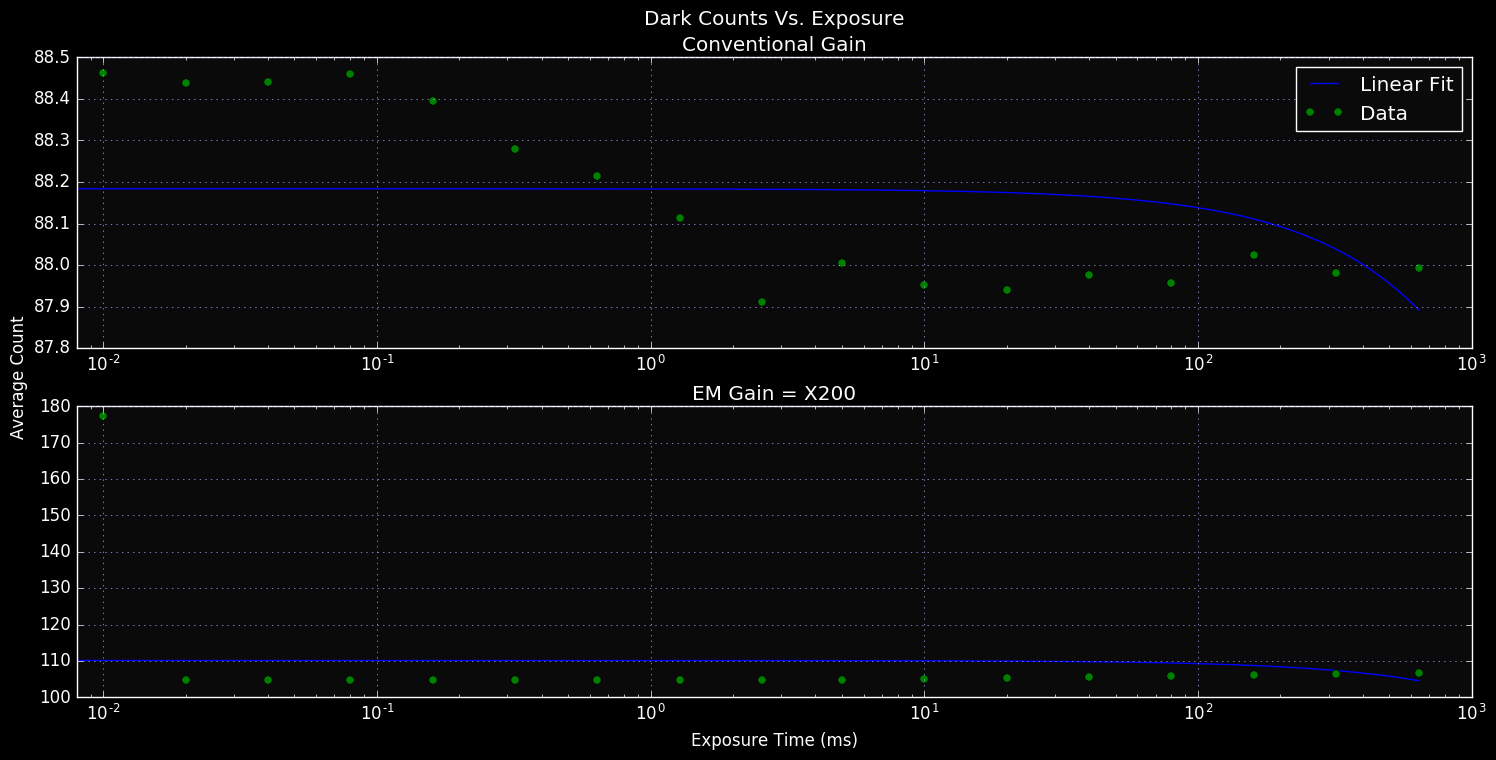

Conventional Gain Slope = -0.000455042297441 +- 9.26507925333e-15
EM Gain Slope = -0.00866639933096 +- 5.21550507725e-07


In [118]:
# 
fig = plt.figure(1)
splt = fig.add_subplot(211)
splt.plot(xData, convFitData, label='Linear Fit')
splt.plot(exposures, convAvgs, linestyle='', marker='o', label='Data')
splt.set_xscale("log", nonposx='clip')
splt.set_title('Conventional Gain')
splt.legend()

splt = plt.subplot(212, sharex=splt)
splt.plot(xData, em200FitData)
splt.plot(exposures, em200Avgs, linestyle='', marker='o')
splt.set_xscale("log", nonposx='clip')
splt.set_title('EM Gain = X200')
splt.set_xlim([8*10**-3, 1000])

ax = fig.add_subplot(111, frameon=False)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.grid(False)
plt.yticks([], [])
plt.xticks([], [])
ax.set_ylabel('Average Count', labelpad=35)
ax.set_xlabel('Exposure Time (ms)', labelpad=25)
ax.set_title('Dark Counts Vs. Exposure',y=1.04)
plt.show()
print('Conventional Gain Slope = ' + str(convFit[0]) + " +- " + str(convCov[0][0]**2))
print('EM Gain Slope = ' + str(em200Fit[0]) + " +- " + str(em200Cov[0][0]**2))

This looks very strange! There appears to be very negligible actual dark photon count, but there appears to be something happening at low exposure times (more so for conventional gain!) that causes the background count to rise. Thankfully I don't think this should affect our measurements... the effect appears to pretty clearly be gone by 2ms or so for conventional gain. I have no idea what could cause this. The only thing that I can think of is that there is some extra electronic noise involved in very short exposure times.